# import library

In [1]:
import numpy as np
import pandas as pd

In [2]:
import statsmodels.api as sm
print(sm.__version__)

0.14.4


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

In [4]:
region_list = [
    "Eastern Asia",
    "Southern Asia",
    "Northern America",
    "Western Asia",
    "Africa",
    "Eastern Europe",
    "Western Europe",
    "Latin America and the Caribbean",
    "Southern Europe",
    "Northern Europe",
    "South-eastern Asia",
    "Oceania",
]

In [5]:
df_submissions_processed = pd.read_csv(
    "final_data_for_vis/df_submissions_processed_vis.csv",
    index_col=0,
)
print(df_submissions_processed.shape)

(126266, 82)


In [6]:
df_submissions_processed['month'] = df_submissions_processed['month'].astype(str)

In [7]:
df_submissions_published = df_submissions_processed[df_submissions_processed["if_published"]==1]

# Geographical gap in post-rejection publishing outcomes 

## published or not

In [8]:
mod = sm.OLS.from_formula(
    "if_published ~ if_western+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_processed,
)

mod_fit = mod.fit()
df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(f'gap in if_published: {df_param.loc["if_western", "coef"]}')
print(f'p-value: {df_param.loc["if_western", "P>|t|"]:.4f}')

/tmp/ipykernel_2670458/684439905.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


gap in if_published: 0.0594
p-value: 0.0000


In [9]:
mod = sm.OLS.from_formula(
    "if_published ~ C(region)+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_processed,
)

mod_fit_if_published = mod.fit()

## publication probability by the time of rejetcion

In [10]:
mod = sm.OLS.from_formula(
    "if_published ~ C(month_western)+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_processed,
)

mod_fit_month_western = mod.fit()

## Plot two results in Figure 2

/tmp/ipykernel_2670458/4001139323.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_if_published.summary().tables[1].as_html(), header=0, index_col=0)[0]
/tmp/ipykernel_2670458/4001139323.py:84: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_month_western.summary().tables[1].as_html(), header=0, index_col=0)[0]


Text(-6.75, 0.87, 'B')

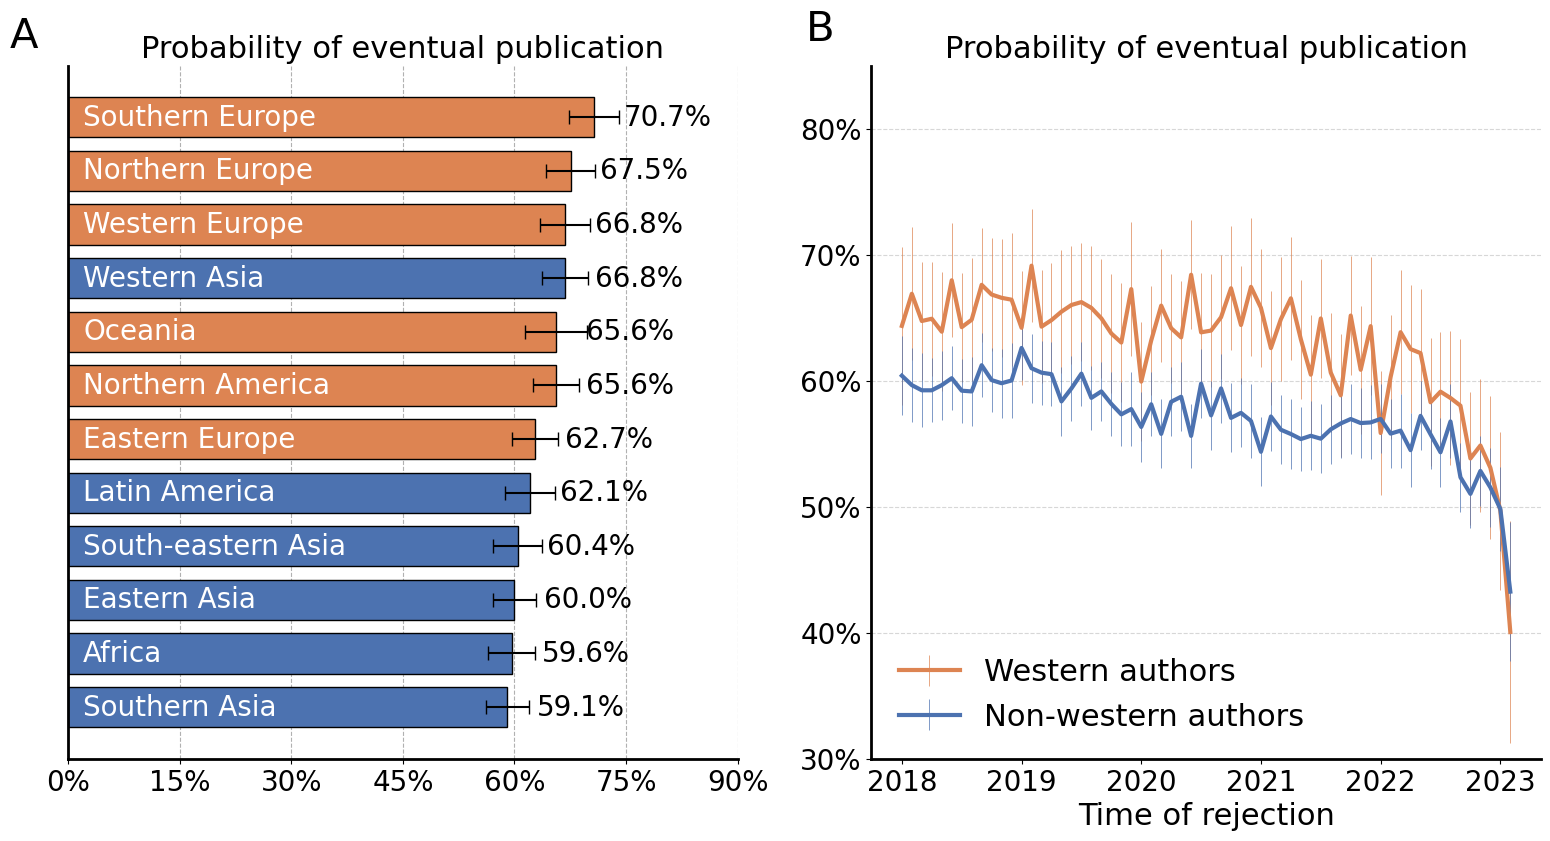

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(19, 9))  # 1 row, 2 columns, and optionally set the figure size

df_param = pd.read_html(mod_fit_if_published.summary().tables[1].as_html(), header=0, index_col=0)[0]

x_region = []
x_region_err = []
color_list = []
x_region_label =[]
for region in region_list:
    index_string = "C(region)[{}]".format(region)
    x_region.append(df_param.loc[index_string, "coef"])
    x_region_err.append(1.96 * df_param.loc[index_string, "std err"])
    x_region_label.append(region)
    
    if region in [
        "Western Europe",
        "Northern Europe",
        "Eastern Europe",
        "Southern Europe",
        "Northern America",
        "Oceania",
    ]:
        color_list.append("#dd8452")
    else:
        color_list.append("#4c72b0")


# x_region_label = [
#     str(a) for a, b in df_submissions_processed["region"].value_counts().items()
# ]

x_region_label, x_region, x_region_err, color_list = zip(
    *sorted(zip(x_region_label, x_region, x_region_err, color_list), key=lambda x: x[1])
)

axs[0].barh(
    np.arange(12) + 0.2,
    x_region,
    color=color_list,
    xerr=x_region_err,
    height=0.75,
    edgecolor="black",
    capsize=5,
    zorder=2,
)  # originally 0.7

axs[0].set_xticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
# axs[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axs[0].set_yticks([])
axs[0].set_yticklabels([])

for i, label in enumerate(x_region_label):
    if "Latin" in label:
        label = "Latin America"
    axs[0].annotate(label, xy=(0.02, i + 0.2), fontsize=20, va="center", color="white")

    axs[0].annotate(
        f"{x_region[i]:.1%}",
        xy=(x_region[i] + 0.04, i + 0.2),
        ha="left",
        va="center",
        fontsize=20,
        color="black",
    )

axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(2)
axs[0].spines["left"].set_linewidth(2)

axs[0].grid(axis="x", linestyle="--", alpha=0.99)

axs[0].tick_params(axis='y', labelsize=20)  # For y-axis
axs[0].tick_params(axis='x', labelsize=20)  # For x-axis

# axs[0].set_xlabel("Probability of being found published", fontsize=22)
axs[0].set_title("Probability of eventual publication", fontsize=22)

axs[0].text(-0.04, 12.5, "A", horizontalalignment="right", size=30, color="black")

###################################

df_param = pd.read_html(mod_fit_month_western.summary().tables[1].as_html(), header=0, index_col=0)[0]

x_team = []
x_team_err = []

for month_ifwestern in [str(1) + "_" + str(i) for i in range(62)]:
    index_string = "C(month_western)[{}]".format(month_ifwestern)
    x_team.append(df_param.loc[index_string, "coef"])
    x_team_err.append(1.96 * df_param.loc[index_string, "std err"])

y_team = []
y_team_err = []

for month_ifwestern in [str(0) + "_" + str(i) for i in range(62)]:
    index_string = "C(month_western)[{}]".format(month_ifwestern)
    y_team.append(df_param.loc[index_string, "coef"])
    y_team_err.append(1.96 * df_param.loc[index_string, "std err"])


    
axs[1].errorbar(
    np.arange(len(x_team)),
    x_team,
    linewidth=3,
    yerr=x_team_err,
    label="Western authors",
    ecolor="#dd8452",
#     capsize = 3,
#     fmt='o',
    elinewidth=.5,
    color="#dd8452",
)

axs[1].errorbar(
    np.arange(len(y_team)),
    y_team,
    linewidth=3,
    yerr=y_team_err,
    label="Non-western authors",
    ecolor="#4c72b0",
    elinewidth=.5,
    color="#4c72b0",
)

axs[1].set_xticks(range(0, 61, 12))
axs[1].set_xticklabels(
    [
        "2018",
        "2019",
        "2020",
        "2021",
        "2022",
        "2023",
    ],
#     fontsize=12,
)

# ax.set_ylim(0.6, 0.85)
# ax.set_xlim(-1, 63)
axs[1].set_ylim(0.3, 0.85)
axs[1].legend(loc="lower left", frameon=False, fontsize=22)

axs[1].grid(axis="y", linestyle="--", alpha=0.5)

axs[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

axs[1].tick_params(
    axis="both", which="major", left=True, bottom=True, direction="out", labelsize=22
)

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(2)
axs[1].spines["left"].set_linewidth(2)

axs[1].tick_params(axis='y', labelsize=20)  # For y-axis
axs[1].tick_params(axis='x', labelsize=20)  # For x-axis

axs[1].set_xlabel("Time of rejection", fontsize=22)
# axs[1].set_title("Probability of being found published", fontsize=22)
axs[1].set_title("Probability of eventual publication", fontsize=22)

axs[1].text(-6.75, 0.87, "B", horizontalalignment="right", size=30, color="black")

# prestige of journals 

## Impact factor change

In [13]:
mod = sm.OLS.from_formula(
    "IF_publish ~ if_western+\
                    C(gender, Treatment(reference='Unknown'))+\
                    team_size+\
                    C(month, Treatment(reference='0.0')) +\
                    works_count_by_year+\
                    C(journal_name)+\
                    C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_published,
)

mod_fit = mod.fit()
df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(f'gap in impact factor: {df_param.loc["if_western", "coef"]}')
print(f'p-value: {df_param.loc["if_western", "P>|t|"]:.4f}')

gap in impact factor: -0.1685
p-value: 0.0000


/tmp/ipykernel_2670458/987361254.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


## Raw data showing average prestige

In [14]:
reject_means = []
publish_means = []

x_positions = []
region_list = list(set(df_submissions_published["region"].to_list()))
region_list = [i for i in region_list if i==i]
region_list = [i for i in region_list if not i == "Other"]

for i, region in enumerate(region_list):
    lst1 = df_submissions_published[df_submissions_published["region"] == region]["IF_reject"].to_list()
    lst2 = df_submissions_published[df_submissions_published["region"] == region]["IF_publish"].to_list()

    lst11 = []; lst22 = []
    for i1 in lst1:
        if i1==i1:
            lst11.append(i1)
    for i2 in lst2:
        if i2==i2:
            lst22.append(i2)

    reject_means.append(np.mean(lst11))
    publish_means.append(np.mean(lst22))
    
    x_positions.append(i)

In [15]:
pairs_sorted = sorted(
    zip(publish_means, reject_means, region_list), key=lambda x: x[1], reverse=True
)
publish_means_sorted, reject_means_sorted, region_list_sorted = zip(*pairs_sorted)
region_list_sorted = [
    "Latin America" if item == "Latin America and the Caribbean" else item
    for item in region_list_sorted
]

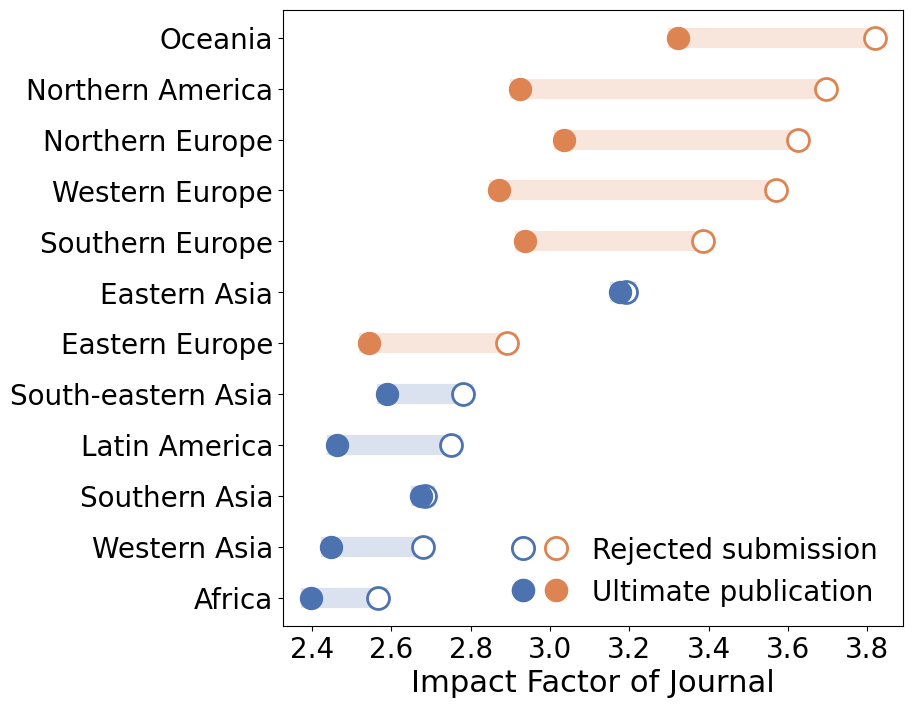

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

for region,i, reject_mean, publish_mean in zip(reversed(region_list_sorted),
    (x_positions), reversed(reject_means_sorted),
reversed(publish_means_sorted)
):
    if region in [
        "Western Europe",
        "Northern Europe",
        "Eastern Europe",
        "Southern Europe",
        "Northern America",
        "Oceania",
    ]:
        plt.scatter([reject_mean],[i], edgecolors="#dd8452", alpha=1,zorder=10,
                    facecolors='white', s=250, linewidths=2)
        plt.scatter([publish_mean],[i], color="#dd8452", s=250 , alpha=1,zorder=10)
        
        plt.plot(
            [publish_mean, reject_mean],
            [i, i],
            color="#dd8452",
            alpha=0.2,
            linestyle="-",
            linewidth=14.5,
            zorder=1
        )
    else:
        plt.scatter([reject_mean], [i], edgecolors="#4c72b0", alpha=1,zorder=10,
                    facecolors='white', s=250, linewidths=2)
        plt.scatter([publish_mean],[i], color="#4c72b0", s=250, alpha=1,zorder=10)

        plt.plot(
            [publish_mean, reject_mean],
            [i, i],
            color="#4c72b0",
            alpha=0.2,
            linestyle="-",
            linewidth=14.5,
            zorder=1
        )
    
circle_1 = mlines.Line2D([], [], color="#4c72b0", markerfacecolor='white',
                         markeredgewidth=2,
                         marker='o', linestyle='None',
                         markersize=16, label='')

circle_2 = mlines.Line2D([], [], color='#4c72b0', marker='o', linestyle='None',
                             markersize=16, label='')

circle_3 = mlines.Line2D([], [], color="#dd8452", markerfacecolor='white', 
                         marker='o', linestyle='None',
                         markeredgewidth=2,
                         markersize=16, label='Rejected submission')

circle_4 = mlines.Line2D([], [], color='#dd8452', marker='o', linestyle='None',
                             markersize=16, label='Ultimate publication')

plt.legend(handles=[circle_1, circle_2, circle_3 ,circle_4],
           fontsize=20, frameon=False, ncol=2,
           handlelength=1, handleheight=1,
           columnspacing=-0.6, 
           bbox_to_anchor=(1.0,-0.01),
           loc='lower right',
          )

plt.yticks(x_positions, reversed(region_list_sorted), fontsize=20, rotation=0)
plt.xticks(fontsize=20)

plt.xlabel("Impact Factor of Journal", fontsize=22)
plt.show()

# regional disparities in publishing outcomes

## probability of authorship change

In [17]:
mod = sm.OLS.from_formula(
    "author_change ~ if_western+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_published,
)

mod_fit = mod.fit()
df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(f'gap in authorship change: {df_param.loc["if_western", "coef"]}')
print(f'p-value: {df_param.loc["if_western", "P>|t|"]:.4f}')

/tmp/ipykernel_2670458/2951301314.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


gap in authorship change: -0.1164
p-value: 0.0000


In [18]:
mod = sm.OLS.from_formula(
    "author_change ~ C(region)+\
                     C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_published,
)

mod_fit_author_change = mod.fit()

## number of days of publication delay

In [19]:
mod = sm.OLS.from_formula(
    "wait_days ~ if_western+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_published,
)

mod_fit = mod.fit()
df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(f'gap in publication delay: {df_param.loc["if_western", "coef"]}')
print(f'p-value: {df_param.loc["if_western", "P>|t|"]:.4f}')

/tmp/ipykernel_2670458/1489887716.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


gap in publication delay: -24.5145
p-value: 0.0000


In [20]:
mod = sm.OLS.from_formula(
    "wait_days ~ C(region)+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_published,
)

mod_fit_wait_days = mod.fit()

## abstract revision

In [21]:
mod = sm.OLS.from_formula(
    "abstract_revising ~ if_western+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_published,
)


mod_fit = mod.fit()
df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(f'gap in abstract revision: {df_param.loc["if_western", "coef"]}')
print(f'p-value: {df_param.loc["if_western", "P>|t|"]:.4f}')

/tmp/ipykernel_2670458/3443856205.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


gap in abstract revision: -0.06
p-value: 0.0000


In [22]:
mod = sm.OLS.from_formula(
    "abstract_revising ~ C(region)+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        works_count_by_year+\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_published,
)

mod_fit_abstract_match = mod.fit()

## Plot three results in Figure 4

/tmp/ipykernel_2670458/602671173.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_wait_days.summary().tables[1].as_html(), header=0, index_col=0)[0]
/tmp/ipykernel_2670458/602671173.py:74: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_abstract_match.summary().tables[1].as_html(), header=0, index_col=0)[0]
/tmp/ipykernel_2670458/602671173.py:147: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_author_change.summary().tables[1].as_html(), header=0, index_col=0)[0]


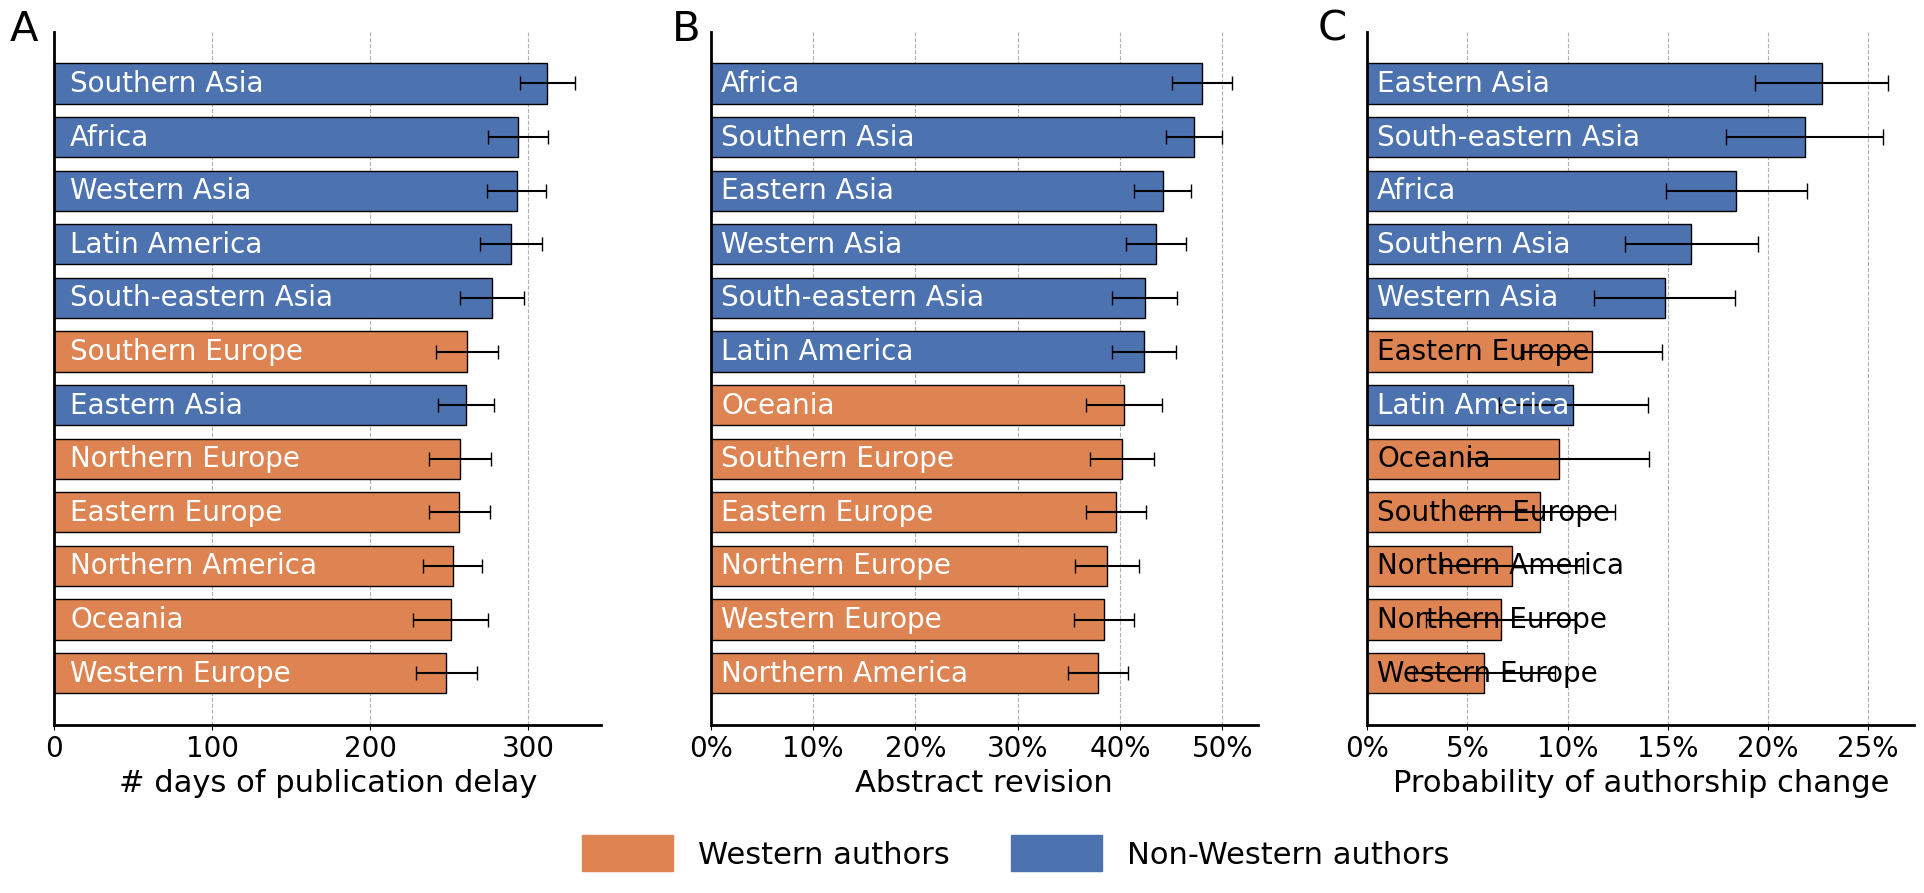

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(24, 9))  # 1 row, 3 columns, and optionally set the figure size

#### 1

df_param = pd.read_html(mod_fit_wait_days.summary().tables[1].as_html(), header=0, index_col=0)[0]

x_region = []
x_region_err = []
color_list = []
x_region_label =[]
for region in region_list:
    index_string = "C(region)[{}]".format(region)
    x_region.append(df_param.loc[index_string, "coef"])
    x_region_err.append(1.96 * df_param.loc[index_string, "std err"])
    x_region_label.append(region)
    if region in [
        "Western Europe",
        "Northern Europe",
        "Eastern Europe",
        "Southern Europe",
        "Northern America",
        "Oceania",
    ]:
        color_list.append("#dd8452")
    else:
        color_list.append("#4c72b0")


x_region_label, x_region, x_region_err, color_list = zip(
    *sorted(zip(x_region_label, x_region, x_region_err, color_list), key=lambda x: x[1])
)

axs[0].barh(
    np.arange(12) + 0.2,
    x_region,
    color=color_list,
    xerr=x_region_err,
    height=0.75,
    edgecolor="black",
    capsize=5,
    zorder=2,
)  # originally 0.7

axs[0].set_yticks([])
axs[0].set_yticklabels([])

for i, label in enumerate(x_region_label):
    if "Latin" in label:
        label = "Latin America"
    
    axs[0].annotate(
        label,
        xy=(10, i + 0.2),
        fontsize=20,
        va="center",
        color="white",
    )

axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(2)
axs[0].spines["left"].set_linewidth(2)

axs[0].grid(axis="x", linestyle="--", alpha=0.99)

axs[0].tick_params(axis='y', labelsize=20)  # For y-axis
axs[0].tick_params(axis='x', labelsize=20)  # For x-axis

axs[0].set_xlabel("# days of publication delay", fontsize=22)
axs[0].text(-10, 12, "A", horizontalalignment="right", size=30, color="black")

#### 2

df_param = pd.read_html(mod_fit_abstract_match.summary().tables[1].as_html(), header=0, index_col=0)[0]
x_region = []
x_region_err = []
color_list = []
x_region_label =[]
for region in region_list:
    index_string = "C(region)[{}]".format(region)
    x_region.append(df_param.loc[index_string, "coef"])
    x_region_err.append(1.96 * df_param.loc[index_string, "std err"])
    x_region_label.append(region)
    if region in [
        "Western Europe",
        "Northern Europe",
        "Eastern Europe",
        "Southern Europe",
        "Northern America",
        "Oceania",
    ]:
        color_list.append("#dd8452")
    else:
        color_list.append("#4c72b0")


x_region_label, x_region, x_region_err, color_list = zip(
    *sorted(zip(x_region_label, x_region, x_region_err, color_list), key=lambda x: x[1])
)

axs[1].barh(
    np.arange(12) + 0.2,
    x_region,
    color=color_list,
    xerr=x_region_err,
    height=0.75,
    edgecolor="black",
    capsize=5,
    zorder=2,
) 

axs[1].set_yticks([])
axs[1].set_yticklabels([])

for i, label in enumerate(x_region_label):
    if "Latin" in label:
        label = "Latin America"
    
    axs[1].annotate(
        label,
        xy=(0.01, i + 0.2),
#         xy=(0.05 * 100, i + 0.2),
        fontsize=20,
        va="center",
        color="white",
    )

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(2)
axs[1].spines["left"].set_linewidth(2)

axs[1].grid(axis="x", linestyle="--", alpha=0.99)
# ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axs[1].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))

axs[1].tick_params(axis='y', labelsize=20)  # For y-axis
axs[1].tick_params(axis='x', labelsize=20)  # For x-axis

axs[1].set_xlabel("Abstract revision", fontsize=22)

axs[1].text(-0.01, 12, "B", horizontalalignment="right", size=30, color="black")


#### 3

df_param = pd.read_html(mod_fit_author_change.summary().tables[1].as_html(), header=0, index_col=0)[0]

x_region = []
x_region_err = []
color_list = []
x_region_label = []
for region in region_list:
    index_string = "C(region)[{}]".format(region)
    x_region.append(df_param.loc[index_string, "coef"])
    x_region_err.append(1.96 * df_param.loc[index_string, "std err"])
    x_region_label.append(region)
    if region in [
        "Western Europe",
        "Northern Europe",
        "Eastern Europe",
        "Southern Europe",
        "Northern America",
        "Oceania",
    ]:
        color_list.append("#dd8452")
    else:
        color_list.append("#4c72b0")

x_region_label, x_region, x_region_err, color_list = zip(
    *sorted(zip(x_region_label, x_region, x_region_err, color_list), key=lambda x: x[1])
)

axs[2].barh(
    np.arange(12) + 0.2,
    x_region,
    color=color_list,
    xerr=x_region_err,
    height=0.75,
    edgecolor="black",
    capsize=6,
    zorder=2,
)  # originally 0.7

# ax.set_xticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
axs[2].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))

axs[2].set_yticks([])
axs[2].set_yticklabels([])

for i, label in enumerate(x_region_label):
    if label in ["Western Europe", "Northern Europe", "Northern America",
#                 "Latin America and the Caribbean", 
                 "Oceania", "Eastern Europe",
                'Southern Europe']:
        axs[2].annotate(
            label, xy=(0.005, i + 0.2), fontsize=20, va="center", ha="left", color="black"
        )
    elif "Latin" in label:
        axs[2].annotate(
            "Latin America", xy=(0.005, i + 0.2), fontsize=20, va="center", ha="left", color="white"
        )
    else:
        axs[2].annotate(
            label, xy=(0.005, i + 0.2), fontsize=20, va="center", ha="left", color="white"
        )
    
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].spines["bottom"].set_linewidth(2)
axs[2].spines["left"].set_linewidth(2)

axs[2].grid(axis="x", linestyle="--", alpha=0.99)

axs[2].tick_params(axis='y', labelsize=20)  # For y-axis
axs[2].tick_params(axis='x', labelsize=20)  # For x-axis

axs[2].set_xlabel("Probability of authorship change", fontsize=22)

axs[2].text(-0.01, 12, "C", horizontalalignment="right", size=30, color="black")

rejected_patch1 = mpatches.Patch(color='#dd8452', label='Western authors')
rejected_patch2 = mpatches.Patch(color='#4c72b0', label='Non-Western authors')

####
plt.legend(handles=[rejected_patch1, rejected_patch2],
           fontsize=22, frameon=False, ncol=2,
           handlelength=3, handleheight=1.4,
          bbox_to_anchor=(0.2,-0.12))


# Resubmission shrinks the initial geographical gap in publishing

In [24]:
df_submissions_merge = pd.read_csv("final_data_for_vis/df_submissions_merge.csv", index_col=0)

df_submissions_merge["revision_submission_date"] = pd.to_datetime(
    df_submissions_merge["revision_submission_date"]
)

df_submissions_2018 = df_submissions_merge[
    df_submissions_merge["revision_submission_date"].dt.year == 2018
]

In [25]:
merge_key = "region"
# merge_key = "Country"

In [26]:
result_1 = (
    df_submissions_merge.groupby(merge_key)["ultimate_publish"]
    .apply(lambda x: (x == "Yes").mean())
    .reset_index()
)

result_1.rename(columns={"ultimate_publish": "Fraction of Acceptation"}, inplace=True)
result_1.head(3)

,region,Fraction of Acceptation
0,Africa,0.246793
1,Eastern Asia,0.369902
2,Eastern Europe,0.441193


In [27]:
result_5 = (
    df_submissions_merge.groupby(merge_key)["ultimate_publish"]
    .apply(lambda x: (x == "NoYes").mean())
    .reset_index()
)
result_5.rename(
    columns={"ultimate_publish": "Fraction of Post-Publication within all"},
    inplace=True,
)
result_5.head(3)

,region,Fraction of Post-Publication within all
0,Africa,0.403305
1,Eastern Asia,0.379720
2,Eastern Europe,0.344349


In [28]:
result_4 = (
    df_submissions_merge.groupby(merge_key)["ultimate_publish"]
    .apply(lambda x: (x != "No").mean())
    .reset_index()
)
result_4.rename(
    columns={"ultimate_publish": "Fraction of Final Acceptation"}, inplace=True
)
result_4.head(3)

,region,Fraction of Final Acceptation
0,Africa,0.650099
1,Eastern Asia,0.749622
2,Eastern Europe,0.785542


In [ ]:
df1 = result_1.merge(result_4, on=merge_key, how="inner")
df1 = df1.merge(result_5, on=merge_key, how="inner")
df1 = df1.merge(result_3, on=merge_key, how="inner")

# df1["if_western"] = df1["region"].apply(lambda x: (("Europe" in x) or ("rn America" in x) or ("Oceania" in x))* 1)

if merge_key == "region":
    df1["if_western"] = df1["region"].apply(
        lambda x: (("Europe" in x) or ("rn America" in x) or ("Oceania" in x))
        * 1)
    
else:
    df1["if_western"] = df1["Country"].apply(
        lambda x: (x in western_country_set) * 1
        if not utils.isNaN(x)
        else 0.5
        #     lambda x: (x in western_country_set) * 1 # how about nan --> nan will become 0 in if_western
    )

    df1 = (
        df1.sort_values(by="Count", ascending=False)
        .head(30)
        .sort_values(by="Fraction of Final Acceptation", ascending=True)
        .reset_index()
    )

df1 = df1[df1[merge_key] != "Other"]
df1 = df1.sort_values(by="Fraction of Final Acceptation", ascending=True).reset_index()

In [31]:
y_all_nw = []
y_all_w = []
for i in range(0,48,1):
    df_w = (
        df_submissions_2018.groupby("if_western")["ultimate_month"]
        .apply(lambda x: (x <= i).mean())
        .reset_index()
    )
    w_list = df_w["ultimate_month"].to_list()
    y_all_nw.append(w_list[0])
    y_all_w.append(w_list[1])

In [32]:
y_acc_nw = []
y_acc_w = []
for i in range(0,48,1):
    df_w = (
        df_submissions_2018.groupby("if_western")["decision_month"]
        .apply(lambda x: (x <= i).mean())
        .reset_index()
    )
    w_list = df_w["decision_month"].to_list()
    y_acc_nw.append(w_list[0])
    y_acc_w.append(w_list[1])

In [33]:
#### Initial gap
print(f'western initial publication rate:{y_acc_w[-1]:.3f}')
print(f'non-western initial publication rate:{y_acc_nw[-1]:.3f}')
print(f'initial publication gap:{y_acc_w[-1]-y_acc_nw[-1]:.3f}')

#### Ultimate gap
print(f'western ultimate publication rate:{y_all_w[-1]:.3f}')
print(f'non-western ultimate publication rate:{y_all_nw[-1]:.3f}')
print(f'ultimate publication gap:{y_all_w[-1]-y_all_nw[-1]:.3f}')

western initial publication rate:0.583
non-western initial publication rate:0.338
initial publication gap:0.246
western ultimate publication rate:0.850
non-western ultimate publication rate:0.722
ultimate publication gap:0.129


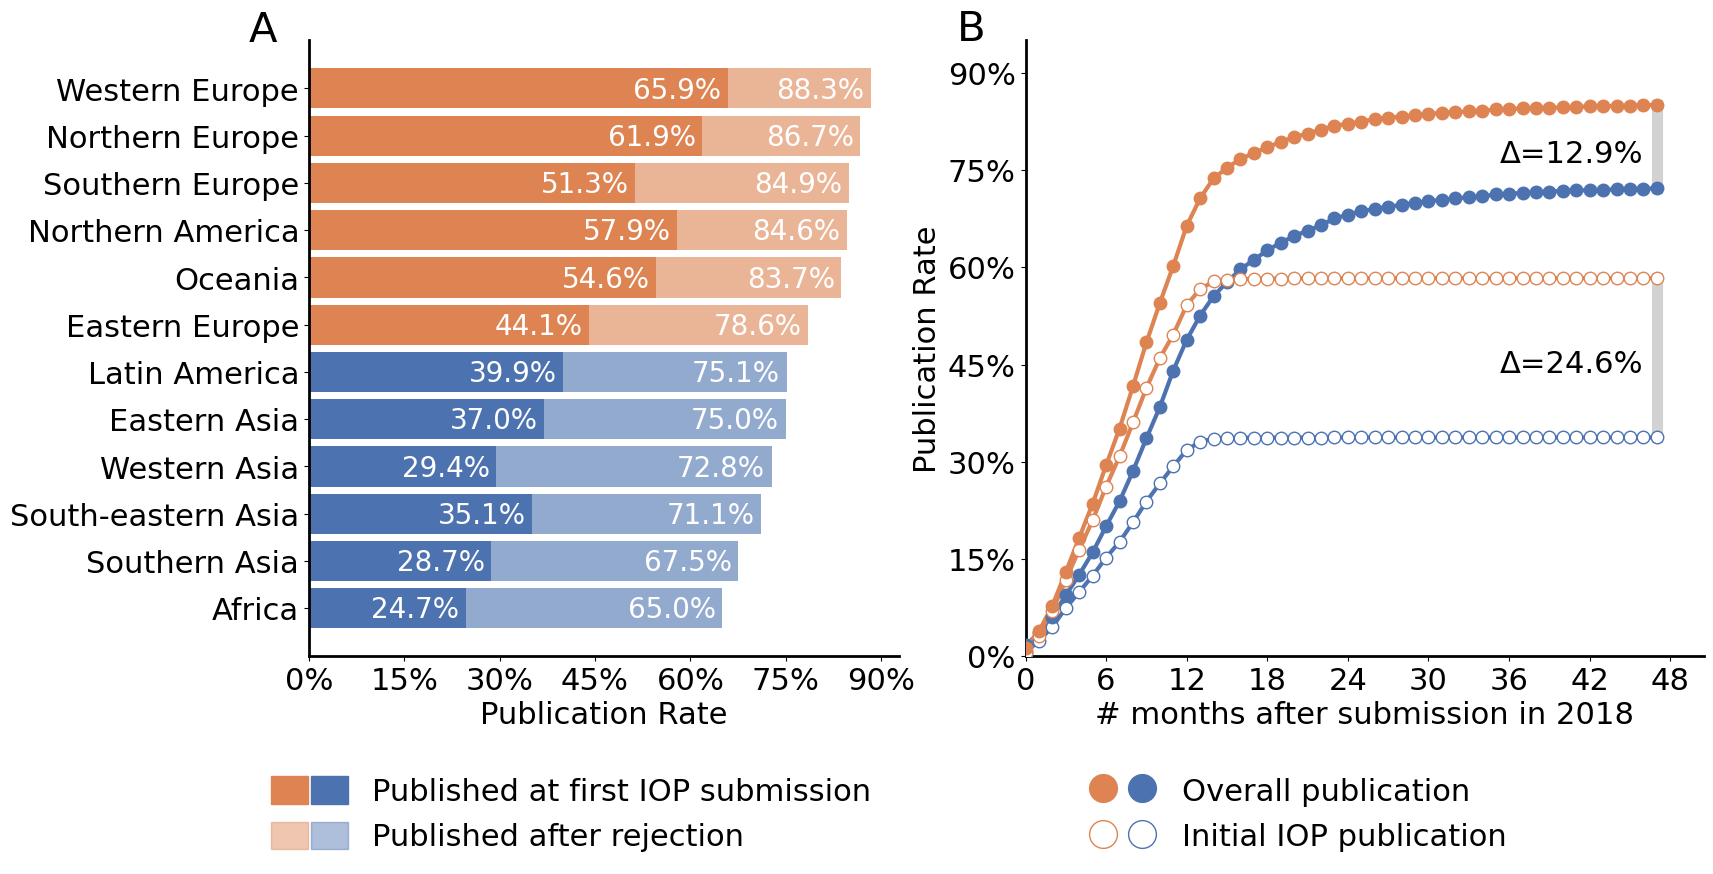

In [35]:
# fig, axs = plt.subplots(1, 2, figsize=(17, 8))

fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 5.75])  # Adjust width ratios to make left narrower

axs = [fig.add_subplot(gs[0]),fig.add_subplot(gs[1])]

################### 1 #####################

custom_palette = {1: "#dd8452", 0: "#4c72b0"}

bar_width = 0.85
for index, row in df1.iterrows():
    axs[0].barh(
        index,
        row["Fraction of Acceptation"],
        color=custom_palette[row["if_western"]],
        height=bar_width,
    )
    
    axs[0].text(
        row["Fraction of Acceptation"] - 0.01,
        index - 0.2,
        f'{row["Fraction of Acceptation"]:.1%}',
        horizontalalignment="right",
        size=20,
        color="white",
    )

    axs[0].barh(
        index,
        row["Fraction of Post-Publication within all"],
        left=row["Fraction of Acceptation"],
        color=custom_palette[row["if_western"]],
        alpha=0.6,
        height=bar_width,
    )
    axs[0].text(
        row["Fraction of Final Acceptation"] - 0.01,
        index - 0.2,
        f'{row["Fraction of Final Acceptation"]:.1%}',
        horizontalalignment="right",
        size=20,
        color="white",
    )

axs[0].set_xlabel("Publication Rate", fontsize=22)
axs[0].set_ylabel("", fontsize=22)

labels = [item for item in df1["region"].to_list()]
new_labels = []
for label in labels:
    if "Latin America" in label:
        new_labels.append("Latin America")
    else:
        new_labels.append(label)

# axs[0].set_yticks(range(len(df1)), new_labels, fontsize=20)
axs[0].set_yticks(range(len(df1)))  # Set the positions of the y-ticks
axs[0].set_yticklabels(new_labels)  # Set the labels and fontsize for y-ticks

axs[0].tick_params(axis='x', labelsize=22)
axs[0].tick_params(axis='y', labelsize=22)
axs[0].tick_params(axis="both", which="major", left=True, bottom=True, direction="out")

# axs[0].set_xlim([0, 1])
axs[0].set_xticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])

# axs[0].set_ylim([-0.5, len(df1) - 0.1])
axs[0].grid(False)
axs[0].xaxis.set_major_formatter(PercentFormatter(1, decimals=0))

axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(2)
axs[0].spines["left"].set_linewidth(2)
axs[0].spines["right"].set_visible(False)

axs[0].text(-0.05, 12, f"A",horizontalalignment="right",size=30,color="black")

################### 1 #####################

patch1 = mpatches.Patch(color='#dd8452', label='')
patch2 = mpatches.Patch(color='#dd8452', alpha=0.45, label='')
patch3 = mpatches.Patch(color='#4c72b0', label='Published at first IOP submission')
patch4 = mpatches.Patch(color='#4c72b0', alpha=0.45, label='Published after rejection')

axs[0].legend(handles=[patch1, patch2, patch3, patch4],
           fontsize=22, frameon=False, ncol=2,
           handlelength=1.2, handleheight=1,
           columnspacing=-0.7,
           bbox_to_anchor=(1,-0.15))

################### 1 #####################

nw_color = "#4c72b0"
w_color = "#dd8452"

ms = 9
markersymbol = "o"

x = list(range(0,48,1))

axs[1].plot(x, y_acc_nw, color=nw_color, alpha=0.99, linewidth=3)
axs[1].plot(x, y_acc_nw, linestyle='None', marker=markersymbol, markersize=ms,
        markerfacecolor='white', markeredgecolor=nw_color,zorder=10, alpha=1)

axs[1].plot(x, y_all_nw, color=nw_color, alpha=1, linewidth=3)
axs[1].plot(x, y_all_nw, linestyle='None', marker=markersymbol, markersize=ms,
        markerfacecolor="#4c72b0", markeredgecolor=nw_color,zorder=10, alpha=1)

axs[1].plot(x, y_acc_w, color=w_color, alpha=0.99, linewidth=3)
axs[1].plot(x, y_acc_w, linestyle='None', marker=markersymbol, markersize=ms,
        markerfacecolor='white', markeredgecolor=w_color,zorder=10, alpha=1)

axs[1].plot(x, y_all_w, color=w_color, alpha=1, linewidth=3)
axs[1].plot(x, y_all_w, linestyle='None', marker=markersymbol, markersize=ms,
        markerfacecolor="#dd8452", markeredgecolor=w_color,zorder=10, alpha=1)

axs[1].plot([x[-1], x[-1]], [y_acc_nw[-1], y_acc_w[-1]],
            color="gray",alpha=0.35,linestyle="-",linewidth=8)

axs[1].plot([x[-1], x[-1]], [y_all_nw[-1], y_all_w[-1]],
            color="gray",alpha=0.35,linestyle="-",linewidth=8)

axs[1].text(x[-1]-1,y_all_nw[-1]+0.04,f"\u0394={(y_all_w[-1]-y_all_nw[-1])*100:.1f}%",
            horizontalalignment="right",size=22,color="black")

axs[1].text(x[-1]-1,y_acc_nw[-1]+0.1,f"\u0394={(y_acc_w[-1]-y_acc_nw[-1])*100:.1f}%",
            horizontalalignment="right",size=22,color="black")

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(2)
axs[1].spines["left"].set_linewidth(2)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))
axs[1].set_xticks([i*6 for i in range(9)])

axs[1].set_xlabel("# months after submission in 2018", fontsize=22)
axs[1].set_ylabel("Publication Rate", fontsize=22)

axs[1].tick_params(axis='y', labelsize=22)  # For y-axis
axs[1].tick_params(axis='x', labelsize=22)  # For x-axis
axs[1].tick_params(axis='both', which='major', left=True, bottom=True, direction="out")

axs[1].set_yticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])

axs[1].set_ylim(0, 0.95)
axs[1].set_xlim(0, 50.5)

axs[1].text(-3,0.95,"B",horizontalalignment="right",size=30,color="black")

#########################

circle_1 = mlines.Line2D([], [], color='#dd8452', marker='o', linestyle='None',
                             markersize=20, label='')

circle_2 = mlines.Line2D([], [], color="#dd8452", markerfacecolor='white', 
                         marker='o', linestyle='None',
                         markersize=20, label='')

circle_3 = mlines.Line2D([], [], color='#4c72b0', marker='o', linestyle='None',
                             markersize=20, label='Overall publication')

circle_4 = mlines.Line2D([], [], color="#4c72b0", markerfacecolor='white', 
                         marker='o', linestyle='None',
                         markersize=20, label='Initial IOP publication')

axs[1].legend(handles=[circle_1, circle_2, circle_3 ,circle_4],
           fontsize=22, frameon=False, ncol=2,
           handlelength=1, handleheight=1,
              columnspacing=-0.5,
              bbox_to_anchor=(0.75,-0.15))

# plt.show()

# Procedural knowledge: Western co-authors and prior publishing experience

In [8]:
mod = sm.OLS.from_formula(
    "if_published ~ C(works_count_by_year_coded, Treatment(reference='0.00.0'))+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_processed,
)

mod_fit_work = mod.fit()

df_param = pd.read_html(mod_fit_work.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(f'gap betwween author with no prior publication and with 10: {df_param.loc["C(works_count_by_year_coded, Treatment(reference='0.00.0'))[T.0.010.0]", "coef"]}')
print(f'p-value: {df_param.loc['C(works_count_by_year_coded, Treatment(reference=\'0.00.0\'))[T.0.010.0]', 'P>|t|']:.4f}')

/tmp/ipykernel_2677162/250619589.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_work.summary().tables[1].as_html(), header=0, index_col=0)[0]


gap betwween author with no prior publication and with 10: 0.1369
p-value: 0.0000


In [8]:
mod = sm.OLS.from_formula(
    "if_published ~ C(works_count_by_year_coded)+\
                        C(gender, Treatment(reference='Unknown'))+\
                        team_size+\
                        C(month, Treatment(reference='0.0')) +\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_processed,
)

mod_fit_work = mod.fit()

In [9]:
df_param = pd.read_html(mod_fit_work.summary().tables[1].as_html(), header=0, index_col=0)[0]

x_nw = [];x_w = [];
x_nw_err = [];x_w_err = [];

for i in range(30):
    index_string = "C(works_count_by_year_coded)[0.0{}]".format(float(i))
    x_nw.append(df_param.loc[index_string, "coef"])
    x_nw_err.append(1.96 * df_param.loc[index_string, "std err"])

    index_string = "C(works_count_by_year_coded)[1.0{}]".format(float(i))
    x_w.append(df_param.loc[index_string, "coef"])
    x_w_err.append(1.96 * df_param.loc[index_string, "std err"])

/tmp/ipykernel_2855447/2384652977.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_fit_work.summary().tables[1].as_html(), header=0, index_col=0)[0]


In [10]:
mod = sm.OLS.from_formula(
    "if_published ~ C(team_composition_coded, Treatment(reference='0.0_4'))+\
                        C(gender, Treatment(reference='Unknown'))+\
                        works_count_by_year+\
                        C(month, Treatment(reference='0.0')) +\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))",
    data=df_submissions_processed,
)
mod_team_fit = mod.fit()

df_param = pd.read_html(mod_team_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]
print(f'gap betwween teams with four western authors and non-western authors: {df_param.loc["C(team_composition_coded, Treatment(reference='0.0_4'))[T.1.0_4]", "coef"]}')
print(f'p-value: {df_param.loc['C(team_composition_coded, Treatment(reference=\'0.0_4\'))[T.1.0_4]', 'P>|t|']:.4f}')

/tmp/ipykernel_2855447/1982001451.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_team_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


gap betwween teams with four western authors and non-western authors: 0.1068
p-value: 0.0000


In [11]:
df_param = pd.read_html(mod_team_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]
print(df_param.loc["C(team_composition_coded, Treatment(reference='0.0_4'))[T.1.0_4]", "coef"])
print(f"{df_param.loc['C(team_composition_coded, Treatment(reference=\'0.0_4\'))[T.1.0_4]', 'P>|t|']:.4f}")

print(f'gap betwween author with no prior publication and with 10: {df_param.loc["C(team_composition_coded, Treatment(reference='0.0_4'))[T.1.0_4]", "coef"]}')
print(f'p-value: {df_param.loc['C(team_composition_coded, Treatment(reference=\'0.0_4\'))[T.1.0_4]', 'P>|t|']:.4f}')

0.1068
0.0000
gap betwween author with no prior publication and with 10: 0.1068
p-value: 0.0000


/tmp/ipykernel_2855447/3785636158.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_team_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


In [12]:
mod = sm.OLS.from_formula(
    "if_published ~ C(team_composition_coded)+\
                        C(gender, Treatment(reference='Unknown'))+\
                        works_count_by_year+\
                        C(month, Treatment(reference='0.0')) +\
                        C(combine, Treatment(reference='R0__Journal of Physics D: Applied Physics'))-1",
    data=df_submissions_processed,
)
mod_team_fit = mod.fit()

In [13]:
df_param = pd.read_html(mod_team_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]

x_nwm = []; x_nwp = []
x_wm = []; x_wp = []
x_nwm_err = []; x_wm_err = []
x_nwp_err = []; x_wp_err = []

for i in range(1, 10):
    index_string = "C(team_composition_coded)[{}]".format("1.0_" + str(i))
    x_wp.append(df_param.loc[index_string, "coef"])
    x_wp_err.append(1.96 * df_param.loc[index_string, "std err"])

    index_string = "C(team_composition_coded)[{}]".format("0.0_" + str(i))
    x_nwp.append(df_param.loc[index_string, "coef"])
    x_nwp_err.append(1.96 * df_param.loc[index_string, "std err"])

    if i > 1:
        index_string = "C(team_composition_coded)[{}]".format("_" + str(i))
        x_wm.append(df_param.loc[index_string, "coef"])
        x_wm_err.append(1.96 * df_param.loc[index_string, "std err"])

/tmp/ipykernel_2855447/2001342284.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_param = pd.read_html(mod_team_fit.summary().tables[1].as_html(), header=0, index_col=0)[0]


Text(-0.5, 0.93, 'B')

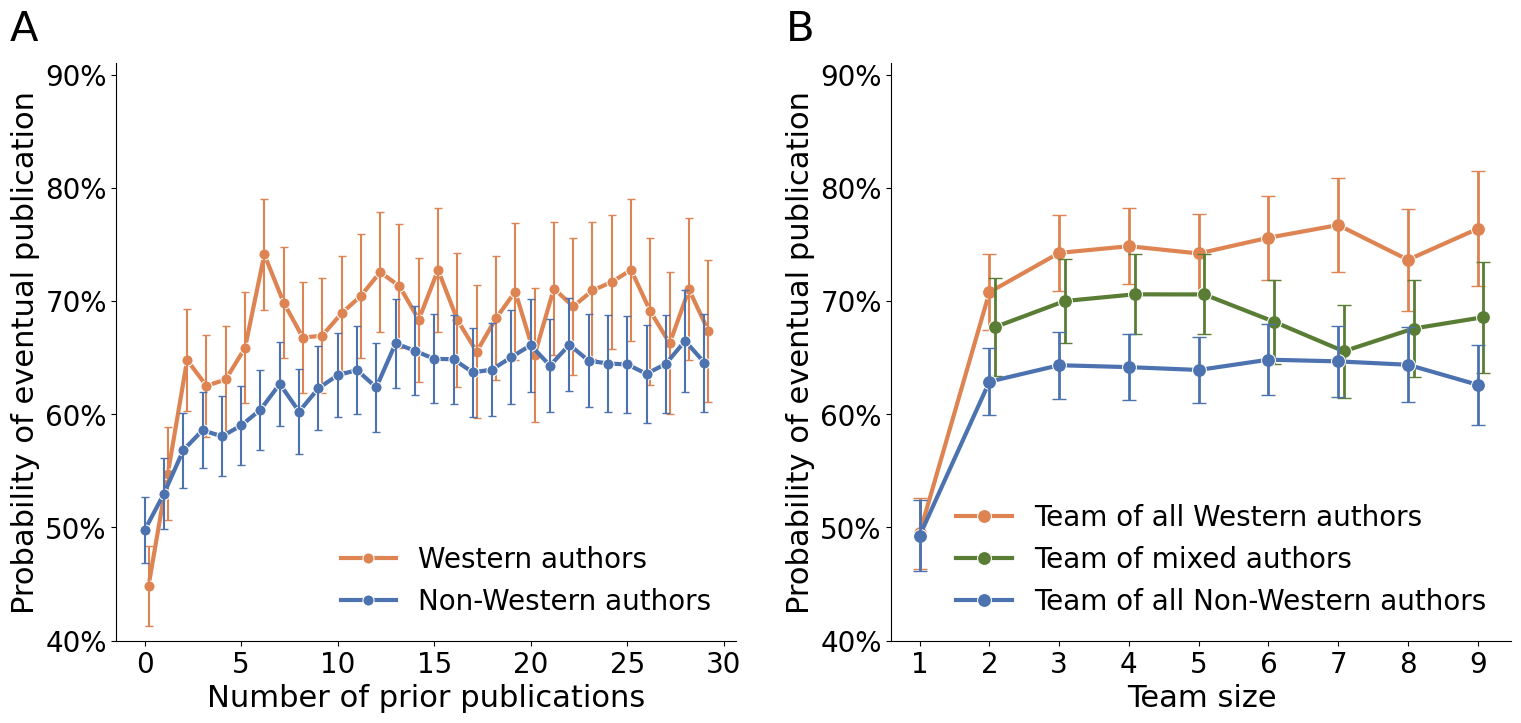

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7.5))  # 1 row, 2 columns, and optionally set the figure size
fig.subplots_adjust(wspace=0.25)  # Adjust the left, right, and the space between the subplots

df = pd.DataFrame({
    'x': np.arange(len(x_nw)),
    'x_nw': x_nw,
    'x_w': x_w,
    'x_nw_err': x_nw_err,
    'x_w_err': x_w_err
})

# Plot first line with a slight offset on the x-axis
sns.lineplot(ax=axs[0], x=df['x'] + 0.2, y='x_w', data=df, linewidth=3,
             color="#dd8452", label='Western authors', marker='o', markersize=8)
axs[0].errorbar(df['x'] + 0.2, df['x_w'], yerr=df['x_w_err'],
                fmt='-', color='none', ecolor='#dd8452', elinewidth=1.5, capsize=3)

####################################

sns.lineplot(ax=axs[0], x='x', y='x_nw', data=df, linewidth=3,
             color="#4c72b0", label='Non-Western authors', marker='o', markersize=8)
axs[0].errorbar(df['x'], df['x_nw'], yerr=df['x_nw_err'],
                fmt='-', color='none', ecolor='#4c72b0', elinewidth=1.5, capsize=3)

axs[0].set_xlabel("Number of prior publications", fontsize=22)
axs[0].set_ylabel("Probability of eventual publication", fontsize=22)

axs[0].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axs[0].set_ylim(0.4, 0.91)
axs[0].tick_params(axis="both", which="major", left=True, bottom=True, direction="out", labelsize=20)
axs[0].legend(fontsize='20', frameon=False, loc='lower right')
axs[0].text(-5.5,0.93,"A",horizontalalignment="right",size=30,color="black")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
#####################################

dfm = pd.DataFrame({
    'x': np.arange(2,2+len(x_wm)),
    'x_w': x_wm,
    'x_w_err': x_wm_err,
})

dfp = pd.DataFrame({
    'x': np.arange(1,1+len(x_wp)),
    'x_nw': x_nwp,
    'x_w': x_wp,
    'x_nw_err': x_nwp_err,
    'x_w_err': x_wp_err
})
greencolor = "#597d35"

sns.lineplot(ax=axs[1], x='x', y='x_w', data=dfp, linewidth=3, 
             color="#dd8452", label='Team of all Western authors', marker='o', markersize=10)
axs[1].errorbar(dfp['x'], dfp['x_w'], yerr=dfp['x_w_err'],
                fmt='-', color='none', ecolor='#dd8452', elinewidth=2, capsize=5)


sns.lineplot(ax=axs[1], x=dfm['x']+0.08, y='x_w', data=dfm, linewidth=3, 
             color=greencolor, label="Team of mixed authors", marker='o', markersize=10)
axs[1].errorbar(dfm['x']+0.08, dfm['x_w'], yerr=dfm['x_w_err'],
                fmt='-', color='none', ecolor=greencolor, elinewidth=2, capsize=5)


sns.lineplot(ax=axs[1], x='x', y='x_nw', data=dfp, linewidth=3,
             color="#4c72b0", label='Team of all Non-Western authors', marker='o', markersize=10)
axs[1].errorbar(dfp['x'], dfp['x_nw'], yerr=dfp['x_nw_err'],
                fmt='-', color='none', ecolor='#4c72b0', elinewidth=2, capsize=5)

axs[1].set_xlabel("Team size", fontsize=22)
axs[1].set_ylabel("Probability of eventual publication", fontsize=22)
axs[1].tick_params(axis="both", which="major", left=True, bottom=True, direction="out", labelsize=20)
axs[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axs[1].set_ylim(0.4, 0.91)
axs[1].set_xticks([i for i in range(1,10)])
axs[1].legend(fontsize='20', frameon=False, loc='lower right')
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].text(-0.5,0.93,"B",horizontalalignment="right",size=30,color="black")